In [1]:
import mesa
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import requests
import os
import pickle

from mesa import Agent, Model
from mesa.time import RandomActivation # random order of agent actions
from mesa.space import MultiGrid # multiple agents er cell
from mesa.datacollection import DataCollector

In [ ]:
url_for_carers = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=is_carer"
url_format= "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=ctry,E92000001&dimensions=health_in_general,highest_qualification"
url_for_area_types = "https://api.beta.ons.gov.uk/v1/population-types/UR/area-types"
url_for_observations = "https://api.beta.ons.gov.uk/v1/population-types/UR/dimensions"

unpaid_care_file = 'unpaid_care_data.pkl'
url_for_carers = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=is_carer"

url_general_health = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=health_in_general"
general_health_file = "general_health.pkl"

url_disability = "https://api.beta.ons.gov.uk/v1/population-types/UR/census-observations?area-type=utla23,E06000066&dimensions=disability"
disability_file = "disability.pkl"

headers = {'User-Agent': 'InternshipExerciseSC/1.0'}

def get_ons_data(url_to_fetch):
    response = requests.get(url_to_fetch, headers=headers) 

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        print(f"Data Request successful")
    else:
        print(f"Failed to retrieve data: {response.status_code}")

    return data

def pickle_data(file_path, url):
    if os.path.exists(file_path):
        # Load the data from the file 
        with open(file_path, 'rb') as file:
            data_to_pickle = pickle.load(file)
        print("Data loaded from file") 
    else:
        # Fetch the data from the API 
        data_to_pickle = get_ons_data(url) 
        # Save the data to a file 
        with open(file_path, 'wb') as file:
            pickle.dump(data_to_pickle, file)
        print("Data fetched from API and saved to file")

    return data_to_pickle

def clear_pickled_file(file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_path} has been deleted.")
    else:
        print(f"{file_path} does not exist.")

def process_ons_data(pulled_ons_data):
    processed_data = []
    for item in pulled_ons_data['observations']:
        dimension_data = {}
        for dim in item['dimensions']:
            #turning values into keys and then values into values... Sort-of makes sense...
            dimension_data[dim['dimension']] = dim['option']
        dimension_data['observation'] = item['observation']
        processed_data.append(dimension_data)
    processed_ons_data = pd.DataFrame(processed_data).drop(columns=('2023 Upper tier local authorities'))
    return processed_ons_data

# clear_pickled_file(unpaid_care_file)
# clear_pickled_file(general_health_file)

raw_unpaid_care_data = pickle_data(unpaid_care_file, url_for_carers)
raw_general_health_data = pickle_data(general_health_file, url_general_health)

unpaid_care_data = process_ons_data(raw_unpaid_care_data)
general_health_data = process_ons_data(raw_general_health_data)

raw_disability_data = pickle_data(disability_file, url_disability)
disability_data = process_ons_data(raw_disability_data)
                                  
#this'll be needed for distribution above all else.
#maybe include Does not Apply in provides no unpaid care?
provides_care_df = unpaid_care_data.drop(axis=0, index=[0])\
.reset_index(drop=True)

#Constants
TOTAL_OBSERVATIONS = unpaid_care_data['observation'].sum()
N_DOES_PROVIDE_CARE = provides_care_df['observation'].sum()
N_DOES_NOT_PROVIDE_CARE = unpaid_care_data['observation'].loc[1].sum()

# Creating care distribution
provides_care_df['p_care_band'] = provides_care_df['observation'] / TOTAL_OBSERVATIONS
provides_care_df_sorted = provides_care_df['p_care_band'].sort_values(ascending=True)

provides_care_df
#~agents would do something similar to this to decide if a resident agent is an unpaid carer
def provides_care(n):
    care_capacity_list = []
    for _ in range(n):
        if random.random() < 0.5:
            care_capacity = round(random.uniform(20, 34),1)
            care_capacity_list.append(care_capacity)
        else:
            care_capacity = 0
            care_capacity_list.append(0)

#Getting there, this'll just be some idle data filling now...
#Additionally, deciding whether a resident agent is a carer is also quite close to this...

    return care_capacity_list

provides_care_df.plot()


coordinator register {}


(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

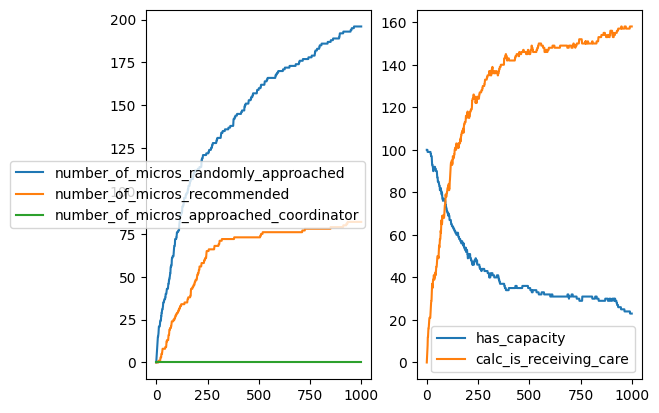

In [ ]:
"""
==To-Do==

** refactor exercise

*  STARTED differentiate contracting fucntion from randomly approaching a microprovider

* incorporating resident movement
    - how do resident's move around their enviornment
    - should they move randomly?
    - No idea really how this should work...

* rounding problem - you know what it is...

* Adding more detail into how micro-provider quality is generated
    how can micro-provider quality increase over time?

* Adding in more detail around how interventions might make a difference to
  micros

* Consider how this will be packaged in a dashboard for people to try.
    - streamlit

1/2* Adding in how microproviders can leave the model, how unpaid carers can leave
  the model
    
THOUGHTS:    

Inevitably out in the community residents needs will become too complex to be
safely delivered by a micro-provider.
Micros will deliver care when they really should be, sometimes...
Micros will recognise when they need to stop delivering care...
A way of warming the model, it all happens just at once at the moment.

potential interventions:
    Increasing the amount of people able to use micro-providers
    Increasing the amount of people able to use micro-providers safely
    Increasing the amount of micro-providers
"""

class Resident_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.unpaidcarers = []
        self.unpaidcare_rec = []
        self.microproviders = []
        self.packages_of_care_rec = []
        self.microproviders_to_recommend = []
        self.blacklisted_microproviders = []
        self.care_needs_met = False
        self.care_needs = 0
        self.micro_quality_threshold = 0
        self.initiate_care_needs()
        self.initiate_micro_quality_threshold()
        
    def initiate_care_needs(self):
        self.generate_care_needs = round(random.uniform(10,20),1)
        self.care_needs = self.generate_care_needs

    def initiate_micro_quality_threshold(self):
        self.generate_mic_qual_thrshld = round(random.uniform(0,1),3)
        self.micro_quality_threshold = self.generate_mic_qual_thrshld
    
    def decide_needs_met(self):
        concat_list = self.packages_of_care_rec + self.unpaidcare_rec
        if self.care_needs <= sum(concat_list):
            self.care_needs_met = True
        else:
            self.care_needs_met = False

    # this might not do anything as most recommendations get passed on to resident
    # and they try them because they're on their own list, rather than just the 
    # carers list - i.e., carers are too good at passing on recommendations to 
    # residents already
    def check_unpaidcarers_microproviders(self):
        carer_micro_list = []
        for unpaidcarer in self.unpaidcarers:
            carer_micros = model.unpaidcarer_agent_registry[unpaidcarer]['microproviders_to_recommend']
            carer_micro_list.extend(carer_micros)

        possible_micros = [mp for mp in carer_micro_list if mp not in carer_micro_list]
        
        if not possible_micros:
            return False

        carer_recommended_microprovider_id = random.choice(possible_micros)
        carer_recommended_microprovider_object = model.microprovider_agent_registry[carer_recommended_microprovider_id]['agent_object']
        
        if self.contract_microprovider(carer_recommended_microprovider_id, carer_recommended_microprovider_object):
            model.num_micros_approached_carer_recommended += 1
            print(
            f'resident {self.unique_id} has approached microprovider'
            f' {carer_recommended_microprovider_id} recommended by an unpaid carer'
            )
            return True

        return False

    def check_recommended_microproviders(self):
        possible_micros = [mp for mp in self.microproviders_to_recommend if mp not in self.microproviders]
        
        if not possible_micros:
            return False

        recommended_microprovider_id = random.choice(possible_micros)
        recommended_microprovider_object = model.microprovider_agent_registry[recommended_microprovider_id]['agent_object']
        
        if self.contract_microprovider(recommended_microprovider_id, recommended_microprovider_object):
            model.num_micros_approached_recommended += 1  # Changed from carer_recommended
            return True
        return False

        #     # print(f'resident {self.unique_id} has approached microprovider '
        #     #   f'{recommended_microprovider_id} recommended by other residents')
        
    def contract_random_microprovider(self):
        # function which randomly selects a microprovider from the model and
        # attempts to contract them.
        random_microprovider_id = random.choice(
            list(model.microprovider_agent_registry.keys())
            )
        
        random_microprovider_object = model.microprovider_agent_registry\
            [random_microprovider_id]\
            ['agent_object']
        
        self.contract_microprovider(random_microprovider_id,
                                     random_microprovider_object)
        
        if self.contract_microprovider(random_microprovider_id,
                                       random_microprovider_object):
            model.num_micros_approached_randomly += 1
        # print(f'resident {self.unique_id} has approached microprovider'
        #       f'  {random_microprovider_id} at random')

    def coord_care_brokerage(self):
        if self.model.num_coordinator_agents > 0 and\
        self.model.coordinator_agent_registry[0]['registered_microproviders'] != []:

            eligible_microproviders = []
        
            for micro in self.model.coordinator_agent_registry[0]\
            ['registered_microproviders']:
                micro_object = self.model.microprovider_agent_registry[micro]\
                ['agent_object']

                if micro_object.has_capacity and\
                micro_object.micro_quality >= self.micro_quality_threshold:
                    eligible_microproviders.append(micro)

            def brokerage_contract(eligible_microproviders):       
                if eligible_microproviders:
                    random.shuffle(eligible_microproviders)  # Randomize the order
        
                    for micro_id in eligible_microproviders:
                        micro_object = self.model.microprovider_agent_registry[micro_id]\
                        ['agent_object']
                    
                        if self.contract_microprovider(micro_id, micro_object):
                            return True  # Stop after successful contract    
                    return False  # Return False if no successful contract was made
            
            if brokerage_contract(eligible_microproviders):
                # print(f"coordinator matched {self.unique_id} with microprovider")
                self.model.num_micros_approached_coordinator += 1
                return True
        return False

    def contract_microprovider(self,allocated_microprovider_id,
                                allocated_microprovider_object):
        # process of contracting a microprovider
        # if the microprovider is not blacklisted and has a high enough quality
        # score
        if allocated_microprovider_id not in self.blacklisted_microproviders and\
            allocated_microprovider_object.micro_quality >=\
            self.micro_quality_threshold: 
            if allocated_microprovider_object.has_capacity:
            # make sure the microprovider is not already contracted--at at any
            # given time we're assuming that a microprovider is only contracted
            # once!
                if allocated_microprovider_id not in self.microproviders:
                    # how much capacity will this micro-provider give?
                    care_delivered = round(
                        random.uniform(
                            1,
                            model.microprovider_agent_registry\
                            [allocated_microprovider_id]\
                            ['agent_care_capacity']),
                        1)
                    # append selected microprovider to residents list of micros
                    self.microproviders.append\
                        (allocated_microprovider_object.unique_id)
                    # append package of care to packages of care received
                    self.packages_of_care_rec.append\
                        (care_delivered)
                    # append resident to microproviders list of residents
                    allocated_microprovider_object.residents.append\
                        (self.unique_id)
                    # append resident's package of care to microproviders
                    # packages of care
                    allocated_microprovider_object.packages_of_care.append\
                        (care_delivered)             
                    #update residents care needs met
                    self.decide_needs_met()
                    #update microproviders care capacity going forward
                    allocated_microprovider_object.decide_capacity()

                return True
        
    def review_care_received(self):
        last_reviewed_index = None
        # access micros and packages of care they supply
        for index, micro in enumerate(self.microproviders):
            # decide if you want to review the package of care
            review_micro = random.choice([True, False])
            # print(f"review micro = {review_micro}")
            # deciding to review package of care
            if review_micro:
                last_reviewed_index = index
                micro_object = model.microprovider_agent_registry[micro]\
                ['agent_object']
                # review outcome positive
                if self.micro_quality_threshold <= micro_object.micro_quality:
                    # print(
                    #     f"resi {self.unique_id} is happy with the care that "
                    #     f"{micro_object.unique_id} is giving"
                    #     )
                    promote_micro = random.choice([True, False])
                    # choosing to promote microprovider when next chat to residents
                    if promote_micro and\
                    micro not in self.microproviders_to_recommend:
                        self.microproviders_to_recommend.append(micro)
                        # print(
                        #     f"resident {self.unique_id} has added microprovider "
                        #     f"{micro} to their list of microproviders they would "
                        #      "recommend"
                        # )
                    # choosing not to promote micro but happy with care
                    if not promote_micro:
                        pass
                # not happy with package of care and deciding to remove micro
                if not self.micro_quality_threshold + 0.2\
                    <= micro_object.micro_quality:
                    # print(
                    #     f"resident {self.unique_id} is not happy with the care "
                    #     f"they are receiving from microprovider {micro}"
                    # )
                    # blacklisting microprovider so a resident won't contract
                    # them again
                    self.blacklisted_microproviders.append(micro)
                    # removing package of care from package of care received
                    pckg_t_rmv = self.packages_of_care_rec[index]
                    self.packages_of_care_rec.remove(pckg_t_rmv)
                    # print(
                    #     f"resident {self.unique_id} removed micro {micro} "
                    #     f"and their package of care {pckg_t_rmv}"
                    # )
                    # removing microprovider from list and recommendation list
                    # if unhappy
                    self.microproviders.remove(micro)
                    if micro in self.microproviders_to_recommend:
                        self.microproviders_to_recommend.remove(micro)

                    #removing resident from microproviders records also
                    
                    # before removing them, find where the resident is in the
                    # micros packages of care.
                    resi_index = micro_object.residents.index(self.unique_id)
                    resi_package = micro_object.packages_of_care[resi_index]

                    # print(
                    #     f"resident {self.unique_id} is position {resi_index} "
                    #     f"in the micros package of care list, and they give "
                    #     f"{resi_package} care"
                    # )
                    
                    # print(
                    #     f"resident {self.unique_id} instructes micro "
                    #     f"{micro_object.unique_id} to remove them"
                    # )

                    micro_object.residents.remove(self.unique_id)
                    micro_object.packages_of_care.remove(resi_package)

                    # print(
                    #     f"micro {micro_object.unique_id} revised packages of care " 
                    #     f"are {micro_object.packages_of_care}"
                    # )

            if not review_micro:
                pass

    def promote_microprovider(self):
        nearby_residents = []
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for inhabitant in cellmates:
            if isinstance(inhabitant, Resident_Agent):
                nearby_residents.append(inhabitant)
        
        resident_to_chat = random.choice(nearby_residents)
        # print(resident_to_chat.microproviders_to_recommend)

        for micro in self.microproviders_to_recommend:
            if micro not in resident_to_chat.microproviders_to_recommend and\
            micro not in resident_to_chat.blacklisted_microproviders:
                resident_to_chat.microproviders_to_recommend.append(micro)
                # print(
                #     f"resident {resident_to_chat.unique_id} added micro {micro} "
                #     f"to their list on reccomendation from resident {self.unique_id}" 
                # )
                
    def step(self):
            self.decide_needs_met()
            if self.care_needs_met == False: 
                if self.check_recommended_microproviders():
                    return
                
                if self.check_unpaidcarers_microproviders():
                    return
                
                if random.random() < 0.01:
                    if self.coord_care_brokerage():
                        return
                    
                else:
                    if random.random() < 0.001:
                        self.contract_random_microprovider()
                        return
                    
            if random.random() < 0.05:
                self.review_care_received()
            
            if random.random() < 0.05:
                self.promote_microprovider()
    
class MicroProvider_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.residents = []
        self.packages_of_care = []
        self.has_capacity = True
        self.care_capacity = 0
        self.micro_quality = 0
        self.initiate_care_capacity()
        self.initiate_micro_quality_threshold()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity

    def initiate_micro_quality_threshold(self):
        self.generate_mic_qual = round(random.uniform(0,1),3)
        self.micro_quality = self.generate_mic_qual

    def decide_capacity(self):
        if sum(self.packages_of_care) > self.care_capacity:
            self.has_capacity = False
        else:
            self.has_capacity = True

    def register_with_coordinator(self):
        if model.num_coordinator_agents > 0:
            if self.unique_id not in model.coordinator_agent_registry[0]['registered_microproviders']\
                and len(self.residents) >= 1\
                and self.micro_quality >= model.coordinator_agent_registry[0]['micro_quality_threshold']:
                # register with coordinator agent
                model.coordinator_agent_registry[0]['registered_microproviders'].\
                    append(self.unique_id)

    def step(self):
        self.decide_capacity()

        if model.num_coordinator_agents > 0 and\
            self.unique_id not in model.coordinator_agent_registry[0]['registered_microproviders']:
            if random.random() < 0.25:
                self.register_with_coordinator()

class UnpaidCare_Agent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.residents = []
        self.unpaidcare_delivered = []
        self.microproviders_to_recommend = []
        self.blacklisted_microproviders = []
        self.has_capacity = True
        self.initiate_care_capacity()

    def initiate_care_capacity(self):
        self.generate_care_capacity = round(random.uniform(5,10),1)
        self.care_capacity = self.generate_care_capacity

    def decide_capacity(self):
        if sum(self.unpaidcare_delivered) > self.care_capacity:
            self.has_capacity = False
        else:
            self.has_capacity = True

    def locate_resident(self):
        allocated_resident_id = random.choice(
            list(model.resident_agent_registry.keys())
            )
        
        allocated_resident_object = model.resident_agent_registry\
            [allocated_resident_id]\
            ['agent_object']

        if self.has_capacity and\
            self.unique_id not in allocated_resident_object.unpaidcarers:

                care_delivered = round(
                    random.uniform(1, self.care_capacity),
                    1
                )
                #append selected microprovider to residents list of micros
                self.residents.append\
                    (allocated_resident_object.unique_id)
                #append package of care to packages of care received
                self.unpaidcare_delivered.append\
                    (care_delivered)
                #append resident to microproviders list of residents
                allocated_resident_object.unpaidcarers.append\
                    (self.unique_id)
                #append resident's package of care to microproviders packages of care
                allocated_resident_object.unpaidcare_rec.append\
                    (care_delivered)             
                #update residents care needs met
                allocated_resident_object.decide_needs_met()
                #update microproviders care capacity going forward
                self.decide_capacity()            
        
    def fetch_microproviders(self):
        if len(self.residents) > 0:
            for resident_id in self.residents:
                resident_object = self.model.resident_agent_registry\
                    [resident_id]['agent_object']
                
                # Get the microproviders this resident recommends
                resident_recommended_microproviders = resident_object\
                    .microproviders_to_recommend
                
                # Add recommended microproviders to unpaid carer's list
                # if not already there
                for micro_id in resident_recommended_microproviders:
                    if micro_id not in self.microproviders_to_recommend:
                        self.microproviders_to_recommend.append(micro_id)

    def promote_microprovider(self):
        nearby_residents = []
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for inhabitant in cellmates:
            if isinstance(inhabitant, Resident_Agent) or\
            isinstance(inhabitant, UnpaidCare_Agent):
                 nearby_residents.append(inhabitant)
        
        if nearby_residents:
            resident_to_chat = random.choice(nearby_residents)
            # print(resident_to_chat)

            if self.microproviders_to_recommend:
                for micro in self.microproviders_to_recommend:
                    if micro not in resident_to_chat.microproviders_to_recommend and\
                        micro not in resident_to_chat.blacklisted_microproviders:
                        resident_to_chat.microproviders_to_recommend.append(micro)
                        # print(
                        #     f"agent{resident_to_chat}, {resident_to_chat.unique_id} added micro {micro} "
                        #     f"to their list of reccomendations from unpaid care agent {self.unique_id}" 
                        # )
    
    def step(self):
        if self.has_capacity:
            self.locate_resident()
        self.fetch_microproviders()

        if random.choice([True, False]):
            self.promote_microprovider()

class Coordinator_Agent(Agent):
    # constructor
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.registered_microproviders = []
        self.micro_quality_threshold = 0.5

    # micro-providers have a chance to register with coordinator

    # brokerage function - microproviders can be recommended to residents
    # resident approaches coordinator and asks for a microprovider
    # coordinator iterates through list of microproviders and recommends one
    # needs to have high enough quality socre and have capacity


    def step(self):
        pass

class Care_Model(Model):
    # constructor
    def __init__(self,
                N_RESIDENT_AGENTS,
                N_MICROPROVIDER_AGENTS,
                N_UNPAIDCARE_AGENTS,
                N_COORDINATOR_AGENTS,
                width,
                height
                ):
        super().__init__()

        # models own variables
        self.num_resident_agents = N_RESIDENT_AGENTS
        self.num_microprovider_agents = N_MICROPROVIDER_AGENTS
        self.num_unpaidcare_agents = N_UNPAIDCARE_AGENTS
        self.num_coordinator_agents = N_COORDINATOR_AGENTS
        self.running = True
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # counter of number of micros approached any what way
        self.num_micros_approached_randomly = 0
        self.num_micros_approached_recommended = 0
        self.num_micros_approached_carer_recommended = 0
        self.num_micros_approached_coordinator = 0

        # agent registries
        self.resident_agent_registry = {}
        self.microprovider_agent_registry = {}
        self.unpaidcarer_agent_registry = {}
        self.coordinator_agent_registry = {}

        # adding resident agents
        for i in range(self.num_resident_agents):
            a = Resident_Agent(i, self)
            self.schedule.add(a)
            self.resident_agent_registry[i] = {
                'agent_object' : a,
                'agent_id': i,
                'agent_care_needs': a.generate_care_needs,
                'micro_quality_threshold': a.generate_mic_qual_thrshld,
                'care_needs_met': None,
                'allocated_microproviders': None,
                'packages_of_care_received': [],
                'blacklisted_microproviders': None,
                'microproviders_to_recommend': None,
                'unpaidcarers': None,
                'unpaidcare_rec': None
            }
           
            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
            # print(f'placed resident agent {a.pos}')

        # adding micro-provider agents
        for i in range(self.num_microprovider_agents):
            a = MicroProvider_Agent(i, self)
            self.schedule.add(a)
            self.microprovider_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'agent_care_capacity' : a.generate_care_capacity,
                'micro_quality': a.generate_mic_qual,
                'has_capacity': True,
                'allocated_residents': None,
                'packages_of_care_delivered': None
            }

            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))
         
        for i in range(self.num_unpaidcare_agents):
            a = UnpaidCare_Agent(i, self)
            self.schedule.add(a)
            self.unpaidcarer_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'agent_care_capacity': a.generate_care_capacity,
                'has_capacity': a.has_capacity,
                'residents': None,
                'unpaidcare_delivered': None,
                'microproviders_to_recommend': None
            }

            try:
                start_cell = self.grid.find_empty()
                self.grid.place_agent(a, start_cell)
            except:
                x = random.randrange(self.grid.width)
                y = random.randrange(self.grid.height)
                self.grid.place_agent(a, (x,y))

        for i in range(self.num_coordinator_agents):
            a = Coordinator_Agent(i, self)
            self.schedule.add(a)
            self.coordinator_agent_registry[i] = {
                'agent_object': a,
                'agent_id': i,
                'registered_microproviders': [],
                'micro_quality_threshold': a.micro_quality_threshold
            }

        # adding datacollector to model
        self.datacollector = DataCollector(
            model_reporters={
                "calc_allocated_residents":
                  self.calc_allocated_residents,
                "calc_resident_packages":
                  self.calc_packages_of_care_delivered,
                "calc_capacity":
                  self.calc_micro_capacity,
                "has_capacity":
                  self.micro_has_capacity,
                "calc_blacklisted_microproviders":
                  self.calc_blacklisted_microproviders,
                "calc_unpaidcare_received": 
                 self.calc_unpaidcare_received,
                "calc_care_received":
                 self.calc_care_received,
                "calc_care_needs":
                 self.calc_care_needs,
                "calc_is_receiving_care":
                 self.calc_receiving_care,
                 "number_of_micros_randomly_approached":
                 self.calc_num_micros_approached_randomly,
                 "number_of_micros_recommended":
                 self.calc_num_micros_approached_recommended,
                "number_of_micros_carer_recommended":
                 self.calc_num_micros_approached_carer_recommended,
                "number_of_micros_approached_coordinator":
                 self.calc_num_micros_approached_coordinator
            }
        )

    def calc_num_micros_approached_randomly(self):
        num = self.num_micros_approached_randomly
        return num
    
    def calc_num_micros_approached_recommended(self):
        num = self.num_micros_approached_recommended
        return num
    
    def calc_num_micros_approached_carer_recommended(self):
        num = self.num_micros_approached_carer_recommended
        return num
    
    def calc_num_micros_approached_coordinator(self):
        num = self.num_micros_approached_coordinator
        return num
    #microprovider functions
    def calc_allocated_residents(self):
        allocated_residents_total = []
        for x in range(len(model.microprovider_agent_registry)):
            allocated_residents = model.microprovider_agent_registry[x]\
                ['allocated_residents']
            if allocated_residents != None:
                allocated_residents_total.extend(allocated_residents)
            else:
                pass 
        return len(allocated_residents_total)

    def calc_packages_of_care_delivered(self):
        packages_of_care_total = []
        for x in range(len(model.microprovider_agent_registry)):
            packages_of_care = model.microprovider_agent_registry[x]\
                ['packages_of_care_delivered']
            if packages_of_care != None:
                packages_of_care_total.extend(packages_of_care)
            else:
                pass
        return sum(packages_of_care_total)
    
    def calc_micro_capacity(self):
        total_care_capacity = []
        for x in range(len(model.microprovider_agent_registry)):
            care_capacity = (model.microprovider_agent_registry[x]\
                ['agent_care_capacity'])
            total_care_capacity.append(care_capacity)
        return sum(total_care_capacity)

    def micro_has_capacity(self):
        has_capacity = []
        for x in range(len(model.microprovider_agent_registry)):
            microprovider_has_capacity = model.microprovider_agent_registry[x]\
                ['has_capacity']

            if microprovider_has_capacity:
                has_capacity.append(microprovider_has_capacity)
        return len(has_capacity)

    #resident functions
    
    def calc_blacklisted_microproviders(self):
        total_blacklisted_microproviders = []
        for x in range(len(model.resident_agent_registry)):
            blacklisted_microproviders = model.resident_agent_registry[x]\
                ['blacklisted_microproviders']
            if blacklisted_microproviders != None:
                total_blacklisted_microproviders.extend\
                    (blacklisted_microproviders)
            else:
                pass
        return len(total_blacklisted_microproviders)

    def calc_unpaidcare_received(self):
        total_unpaidcare_delivered = []
        for x in range(len(model.resident_agent_registry)):
            unpaidcare_delivered =model.resident_agent_registry[x]\
                ['unpaidcare_rec']
            if unpaidcare_delivered != None:
                total_unpaidcare_delivered.extend(model.resident_agent_registry[x]\
                ['unpaidcare_rec'])
        return sum(total_unpaidcare_delivered)

    def calc_receiving_care(self):
        count_receiving_care = 0
        for x in range(len(model.resident_agent_registry)):
            resi_microproviders = model.resident_agent_registry[x]\
                ['packages_of_care_received']
            if resi_microproviders != []:
                count_receiving_care += 1
        return count_receiving_care

    # should this also include unpaid care??
    def calc_care_received(self):
        total_care_received = []
        for x in range(len(model.resident_agent_registry)):
            care_received = model.resident_agent_registry[x]\
            ['packages_of_care_received']
            # print(care_received)
            if care_received != None:
                total_care_received.extend(care_received)
        return sum(total_care_received)

    def calc_care_needs(self):
        total_care_needs = []
        for x in range(len(model.resident_agent_registry)):
            care_needs = (model.resident_agent_registry[x]\
            ['agent_care_needs'])
            total_care_needs.append(care_needs)
        return sum(total_care_needs)

    # what happens in each step of the model
    def step(self):

        #first, collect data
        self.datacollector.collect(self)

        # what happens in each step for each type of Agent
        for agent in self.schedule.agents:    
            # micro-provider agents
            if isinstance(agent, MicroProvider_Agent):
                self.microprovider_agent_registry[agent.unique_id]\
                    ['allocated_residents'] = agent.residents
                self.microprovider_agent_registry[agent.unique_id]\
                    ['packages_of_care_delivered'] = agent.packages_of_care
                self.microprovider_agent_registry[agent.unique_id]\
                    ['has_capacity'] = agent.has_capacity

            if isinstance(agent, Resident_Agent):
                self.resident_agent_registry[agent.unique_id]\
                    ['allocated_microproviders'] = agent.microproviders
                self.resident_agent_registry[agent.unique_id]\
                    ['packages_of_care_received'] = agent.packages_of_care_rec
                self.resident_agent_registry[agent.unique_id]\
                    ['care_needs_met'] = agent.care_needs_met
                self.resident_agent_registry[agent.unique_id]\
                    ['blacklisted_microproviders']\
                    = agent.blacklisted_microproviders
                self.resident_agent_registry[agent.unique_id]\
                    ['microproviders_to_recommend']\
                    = agent.microproviders_to_recommend
                self.resident_agent_registry[agent.unique_id]\
                    ['unpaidcarers'] = agent.unpaidcarers
                self.resident_agent_registry[agent.unique_id]\
                    ['unpaidcare_rec'] = agent.unpaidcare_rec
                
            if isinstance(agent, UnpaidCare_Agent):
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['residents'] = agent.residents
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['unpaidcare_delivered'] = agent.unpaidcare_delivered
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['has_capacity'] = agent.has_capacity
                self.unpaidcarer_agent_registry[agent.unique_id]\
                    ['microproviders_to_recommend'] =\
                    agent.microproviders_to_recommend

            if isinstance(agent, Coordinator_Agent):
                self.coordinator_agent_registry[agent.unique_id]\
                    ['registered_microproviders'] = agent.registered_microproviders
            # after configuring unique behaviours, each agent steps
            agent.step()
        
        # add next step to schedule        
        self.schedule.step()

#Set the parameters for your model
N_RESIDENT_AGENTS = 1000
N_MICROPROVIDER_AGENTS = 100
N_UNPAIDCARE_AGENTS = 110
N_COORDINATOR_AGENTS = 0
width = 20
height = 20

model = Care_Model(
    N_RESIDENT_AGENTS,
    N_MICROPROVIDER_AGENTS,
    N_UNPAIDCARE_AGENTS,
    N_COORDINATOR_AGENTS,
    width, 
    height)

# Run the model for a certain number of steps
num_steps = 1000
for i in range(num_steps):
    # print(i)
    model.step()

data = model.datacollector.get_model_vars_dataframe()

#copy and paste outputs and just put in sublime text for easy read
# print(f'resident agent register {model.resident_agent_registry}')
# print(f'micro-provider register {model.microprovider_agent_registry}') 
# print(f'unpaid care register {model.unpaidcarer_agent_registry}')
print(f'coordinator register {model.coordinator_agent_registry}') 

def plot(data):
    fig, ax = plt.subplots(1,2)
    data.plot(kind='line', y='number_of_micros_randomly_approached', ax=ax[0])
    data.plot(kind='line', y='number_of_micros_recommended', ax=ax[0])
    # data.plot(kind='line', y='number_of_micros_approached_coordinator', ax=ax[0])
    data.plot(kind='line', y='has_capacity', ax=ax[1])
    data.plot(kind='line', y='calc_is_receiving_care', ax=ax[1])
    # data.plot(kind='line', y='calc_blacklisted_microproviders', ax=ax[1])

    # data.plot(kind='line', y='number_of_micros_carer_recommended', ax=ax[1])
    return fig, ax

plot(data)